In [8]:
import pandas as pd
import datetime as dt

# Load dataset (Replace with your local path)
df = pd.read_excel('Datascience.xlsx')

# 1. Drop rows without CustomerID
df = df.dropna(subset=['CustomerID'])

# 2. Filter out returns (Quantity > 0) and UnitPrice > 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 3. Create 'TotalSum' column
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# 4. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 5. Define a 'Snapshot Date' (1 day after the last transaction in the data)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [9]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                   # Frequency
    'TotalSum': 'sum'                                       # Monetary
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'MonetaryValue'
}, inplace=True)

In [10]:
# Create labels: For Recency, lower is better (5 = most recent)
# For F and M, higher is better (5 = most frequent/highest spender)
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm['M'] = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)

# Concatenate scores to create an RFM Group (e.g., '444')
rfm['RFM_Group'] = rfm.R.astype(str) + rfm.F.astype(str) + rfm.M.astype(str)

# Calculate total score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

In [11]:
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Champions'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Loyal/Potential'
    else:
        return 'At Risk/Hibernating'

rfm['Segment'] = rfm.apply(segment_me, axis=1)

# Quick look at the sizes of your segments
print(rfm['Segment'].value_counts())

Segment
Loyal/Potential        1894
Champions              1685
At Risk/Hibernating     759
Name: count, dtype: int64


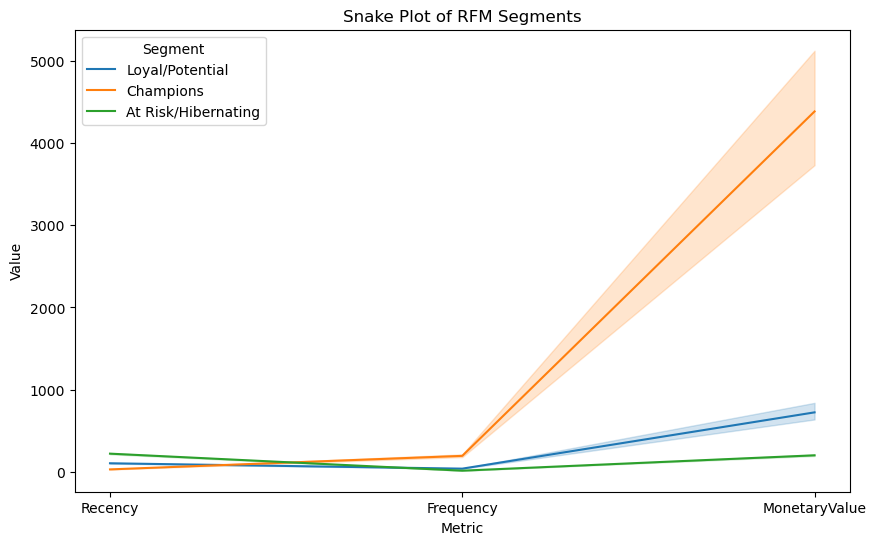

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for plotting
rfm_viz = rfm[['Recency', 'Frequency', 'MonetaryValue', 'Segment']]
rfm_melted = pd.melt(rfm_viz.reset_index(), 
                    id_vars=['CustomerID', 'Segment'], 
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                    var_name='Metric', 
                    value_name='Value')

# Plotting the Snake Plot
plt.figure(figsize=(10, 6))
plt.title('Snake Plot of RFM Segments')
sns.lineplot(x='Metric', y='Value', hue='Segment', data=rfm_melted)
plt.show()

In [15]:
import plotly.express as px

# 1. We'll use the rfm dataframe you already created.
# We include 'CustomerID' (the index) so you can see who is who when hovering.
rfm_reset = rfm.reset_index()

# 2. Create the interactive 3D scatter plot
fig = px.scatter_3d(
    rfm_reset, 
    x='Recency', 
    y='Frequency', 
    z='MonetaryValue',
    color='Segment',
    opacity=0.7,
    title='Interactive 3D Customer Segmentation',
    # Adding hover data shows specific values when you move your mouse over a point
    hover_data=['CustomerID', 'RFM_Score'],
    color_discrete_map={
        'Champions': 'orange',
        'Loyal/Potential': 'blue',
        'At Risk/Hibernating': 'green'
    }
)

# 3. Use log scales for Frequency and Monetary to handle outliers
fig.update_layout(
    scene = dict(
        xaxis_title='Recency (Days)',
        yaxis_title='Frequency (Log)',
        zaxis_title='Monetary (Log)',
        yaxis_type="log",
        zaxis_type="log"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# 4. Display the plot
fig.show()

# 5. Optional: Save as an HTML file to upload to your portfolio/website
# fig.write_html("customer_segmentation_3d.html")